In [129]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
import time
from sklearn.linear_model import LinearRegression
import util
import scipy
from scipy.stats import pearsonr
import math
import seaborn as sns

In [130]:
repo_name = {}

def read_data(filepath):
    d = pd.read_csv(filepath)
    return d

def clean_data():
    curr_millis = int(round(time.time()))

    d = read_data("../data/MLR/watcher.csv")
    repo = d["repo_name"]
    watch_count = d["watch_count"]
    for i in range(len(repo)):
            repo_name[repo[i]] = [watch_count[i], np.nan, np.nan, np.nan, np.nan, np.nan]

    d = read_data("../data/MLR/lang_count.csv")
    repo = d["L_repo_name"]
    lang_count = d["L_lang_count"]
    lan_sum = 0
    count = 0
    for i in range(len(repo)):
            if repo[i] in repo_name:
                    repo_name[repo[i]][1] = lang_count[i]
            if not pd.isnull(lang_count[i]):
                lan_sum += lang_count[i]
                count += 1
    
    mean_lang_count = lan_sum/count
    print(mean_lang_count)
    
    file_sum = 0
    count = 0
    d = read_data("../data/MLR/files_count.csv")
    repo = d["S_repo_name"]
    file_count = d["C_files"]
    for i in range(len(repo)):
            if not pd.isnull(file_count[i]):
                    repo_name[repo[i]][2] = file_count[i]
            if not pd.isnull(file_count[i]):
                file_sum += file_count[i]
                count += 1
    
    mean_file_count = file_sum/count
    print(mean_file_count)

    commiter_sum = 0
    count = 0
    d = read_data("../data/MLR/committer_count.csv")
    repo = d["S_repo_name"]
    committer_count = d["C_committer_count"]
    for i in range(len(repo)):
            if not pd.isnull(committer_count[i]):
                    repo_name[repo[i]][3] = committer_count[i]
            if not pd.isnull(committer_count[i]):
                commiter_sum += committer_count[i]
                count += 1
    
    mean_committer_count = commiter_sum/count
    print(mean_committer_count)

    commit_sum = 0
    count = 0
    d = read_data("../data/MLR/commit_count.csv")
    repo = d["S_repo_name"]
    commit_count = d["C_comm_count"]
    for i in range(len(repo)):
            if not pd.isnull(commit_count[i]):
                    repo_name[repo[i]][4] = commit_count[i]
            if not pd.isnull(commit_count[i]):
                commit_sum += commit_count[i]
                count += 1
    
    mean_commit_count = commit_sum/count
    print(mean_commit_count)

    d = read_data("../data/MLR/committer_date.csv")
    repo = d["S_repo_name"]
    commit_date = d["C_commit_date"]
    for i in range(len(repo)):
            if not pd.isnull(commit_date[i]):
                    dt_obj = datetime.strptime(commit_date[i][:-4],'%Y-%m-%d %H:%M:%S')
                    millisec = dt_obj.timestamp()
                    repo_name[repo[i]][5] = curr_millis - millisec
                    
    repo_name1 = repo_name.copy()
    print(len(repo_name1))
    for i in repo_name.keys():
            if pd.isnull(repo_name[i][5]):
                    del repo_name1[i]

    print(len(repo_name1))
    return (repo_name1, mean_lang_count, mean_file_count, mean_committer_count, mean_commit_count)

In [131]:
(repo_name1, mean_lang_count, mean_file_count, mean_committer_count, mean_commit_count) = clean_data()

2.5628183462
325.597920902
11.4284996691
849.54371336
400000
169216


In [132]:
df = pd.DataFrame.from_dict(repo_name1, orient='index')
df.columns = ["watch_count", "lang_count", "files_count", "committer_count", "commit_count", "commit_date"]
df.to_csv("../data/MLR/Final.csv")

In [133]:
data = pd.read_csv("../data/MLR/Final.csv")

In [197]:
def norm_X(X):
    minimum = util.getMin(X)
    maximum = util.getMax(X)
    for i in range(0,len(X)):
        X[i] = (X[i] - minimum)/(maximum - minimum)
    return X

In [251]:
LC = data['lang_count']
FC = data['files_count']
CC = data['committer_count']
COC = data['commit_count']
CD = data['commit_date']
WC = data['watch_count']
O = np.ones((len(FC),1))

#creating the x matix with the two features and excluding beta_0
X = np.zeros((len(FC),6))
X[:,0] = list(O)[:]
X[:,1] = LC[:]
X[:,2] = FC[:]
X[:,3] = CC[:]
X[:,4] = COC[:]
X[:,5] = CD[:]

null_val_index = np.argwhere(np.isnan(X))
for i in range(0,len(null_val_index)):
    if null_val_index[i][1] == 1:
        X[null_val_index[i][0]] = mean_lang_count
    elif null_val_index[i][1] == 2:
        X[null_val_index[i][0]] = mean_file_count
    elif null_val_index[i][1] == 3:  
        X[null_val_index[i][0]] = mean_committer_count
    elif null_val_index[i][1] == 4:
        X[null_val_index[i][0]] = mean_commit_count

X1 = norm_X(X[:,1])
X2 = norm_X(X[:,2])
X3 = norm_X(X[:,3])
X4 = norm_X(X[:,4])
X5 = norm_X(X[:,5])

X[:,1] = X1[:]
X[:,2] = X2[:]
X[:,3] = X3[:]
X[:,4] = X4[:]
X[:,5] = X5[:]

Y = np.zeros((len(WC),1))
Y[:,0] = WC[:]

In [252]:
lm = LinearRegression()
model = lm.fit(X,Y)
beta = model.coef_.tolist()
Y_pred = model.predict(X)
r2 = model.score(X, Y)
print("beta = " + str(beta))
print("r2 = " + str(r2))

beta = [[-2.9064515993478106, 546.1625410900758, -1642.255338693637, 7057.690685815336, -1308.9502994450627, -158.04270962083646]]
r2 = 0.0268845256679


In [253]:
print("SSE = " + str(util.getSSE(Y,Y_pred)))
print("MAPE = " + str(util.getMAPE(Y,Y_pred)))

SSE = 13391707382.6
MAPE = 541.541546361


In [225]:
def plotfig(X, Y, x_label, y_label):
    plt.figure(figsize=(15,10))
    plt.scatter(X, Y, s=5,alpha=1)
    plt.xlabel(x_label,fontsize=18)
    plt.ylabel(y_label,fontsize=18)
#     plt.ylim(-1000,4000)
#     plt.xlim(-500,1000)
    plt.show()

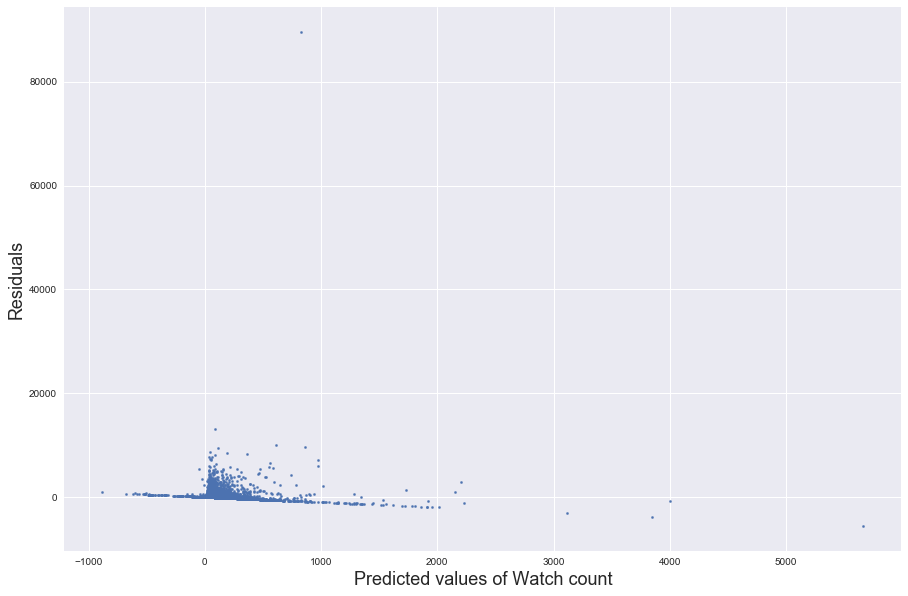

In [226]:
epsilon = Y-Y_pred
plotfig(np.array(Y_pred), np.array(epsilon),'Predicted values of Watch count','Residuals')

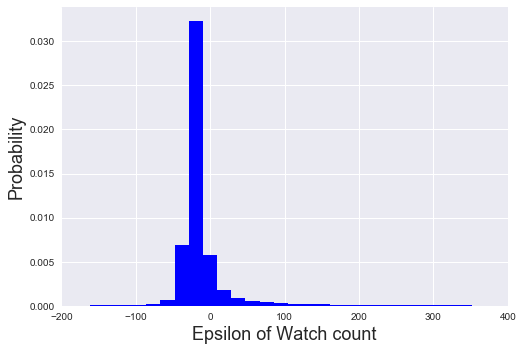

In [227]:
plt.hist(epsilon, bins=5000, facecolor = "Blue", normed=True)
plt.xlim(-200,400)
plt.xlabel('Epsilon of Watch count',fontsize=18)
plt.ylabel('Probability',fontsize=18)
plt.show()

# PART B

In [282]:
XD = np.zeros((len(CC),2))
XD[:,0] = list(O)[:]
XD[:,1] = CC[:]
XC = XD.copy()

CC_val = sorted(XC[:,1])
QR1 = CC_val[42304]
QR2 = CC_val[42304*3]

IQR = QR2 - QR1
R1 = QR1 - 1.5*IQR
R2 = QR2 + 1.5*IQR

ind = []
for i in range(0,len(XD)):
    if XD[i][1] < R1 or XD[i][1] > R2:
        ind.append(i)

new_x1 = np.delete(XD[:,0], ind)
new_x2 = np.delete(XD[:,1], ind)

In [283]:
Y1 = np.zeros((len(WC),1))
Y1[:,0] = WC[:]
Y_new = np.delete(Y1[:,0], ind)

In [284]:
WC_val = sorted(Y_new)
QR1Y = WC_val[37923]
QR2Y = WC_val[113767]

IQRY = QR2Y - QR1Y
R1Y = QR1Y - 1.5*IQRY
R2Y = QR2Y + 1.5*IQRY

indY = []
for i in range(0,len(Y1)):
    if Y1[i][0] < R1Y or Y1[i][0] > R2Y:
        indY.append(i)

In [285]:
Y_new1 = np.delete(Y_new, indY)
Y3 = np.zeros((len(Y_new1),1))
Y3[:,0] = Y_new1[:]

In [286]:
new_x3 = np.delete(new_x1, indY)
new_x4 = np.delete(new_x2, indY)
XB = np.zeros((len(new_x4),2))
XB[:,0] = new_x3[:]
XB[:,1] = new_x4[:]

X1 = norm_X(XB[:,1])
XB[:,1] = X1[:]

In [299]:
XF = np.zeros((len(new_x3),1))
XF[:,0] = new_x3[:]

In [300]:
len(XF)

122890

In [289]:
def pt(X, Y, Y_pred):
    X = np.array(X)
    Y = np.array(Y)
    Y_pred = np.array(Y_pred)

    plt.scatter(X, Y, s=10, c="blue", alpha=1, label="Actual Commit count")
    plt.plot(X, Y_pred, color='orange', linestyle='solid', label="Regression Fit")
    plt.xlabel('Commit count')
    plt.ylabel('Watch count')
    plt.legend()
    plt.show()

In [290]:
lm = LinearRegression()
model1 = lm.fit(XB,Y3)
betaB = model1.coef_.tolist()
r2B = model1.score(XB, Y3)
Y_predB = model1.predict(XB)
print("beta = " + str(betaB))
print("r2 = " + str(r2B))

beta = [[0.0, 3.1621775417434006]]
r2 = 0.0342134254265


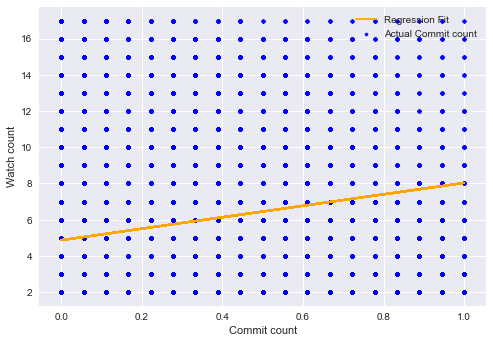

In [302]:
pt(XB[:,1], Y3, Y_predB)

In [292]:
print("SSE = " + str(util.getSSE(Y3,Y_predB)))
print("MAPE = " + str(util.getMAPE(Y3,Y_predB)))

SSE = 1523332.28735
MAPE = 65.2408246982


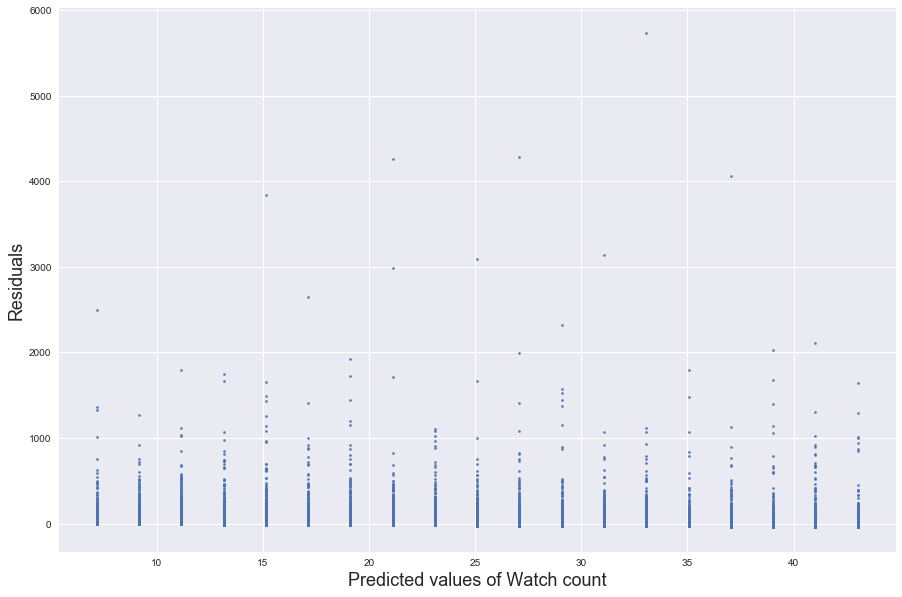

In [273]:
epsilonB = Y3-Y_predB
plotfig(np.array(Y_predB), np.array(epsilonB),'Predicted values of Watch count','Residuals')

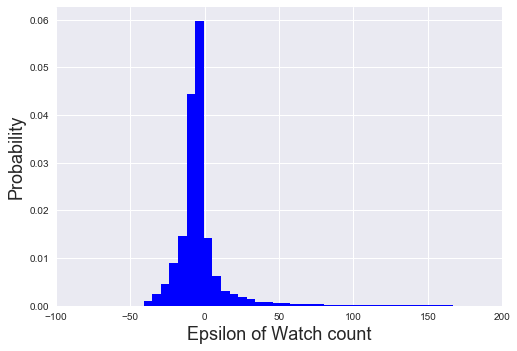

In [279]:
plt.hist(epsilonB, bins=1000, facecolor = "Blue", normed=True)
plt.xlim(-100,200)
plt.xlabel('Epsilon of Watch count',fontsize=18)
plt.ylabel('Probability',fontsize=18)
plt.show()

In [275]:
X3 = X.copy()
X3[:,0] = Y[:,0]
ncols = 6
cvalue = 0
corrs = []
for i in range(0, ncols):
    data1 = X3[:,i:i+1]
    cvalue = cvalue + 1
    for j in range(0, ncols):
        data2 = X3[:,j:j+1]
        corr, n_corr = scipy.stats.pearsonr(data1,data2)
        corrs.append(corr)

In [276]:
inv_colnames = ['Age of Repository = AR','Committers Count = COC','Commit Count = CC','Files Count = FC','Language Count = LC', 'Watchers Count = WC']
colnames = ['WC', 'LC', 'FC', 'CC', 'COC', 'AR']

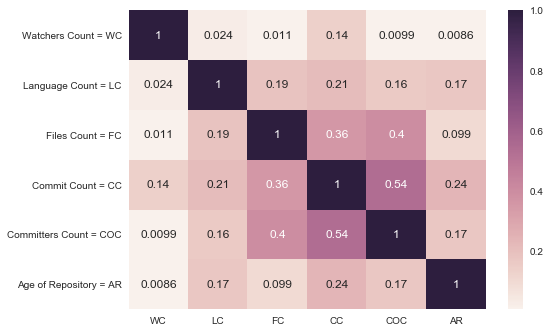

In [277]:
#creating heatmap using seaborn library
a = np.array(corrs).reshape(cvalue,cvalue)
ax = sns.heatmap(a,annot=True)
ax.set_yticklabels(inv_colnames, rotation=0)
ax.set_xticklabels(colnames)
plt.show()